# Exercise 008

<a href="https://colab.research.google.com/github/FAIRChemistry/PythonProgrammingBio24/blob/main/solutions/Exercise008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please execute this cell to download the necessary data
!wget https://raw.githubusercontent.com/JR-1991/PythonProgrammingBio24/main/scripts/utils.py
!wget https://raw.githubusercontent.com/JR-1991/PythonProgrammingBio24/main/data/all_sequences.fasta

from utils import CODON_TABLE, to_triplets

In [ ]:
# Install dependencies
!pip install seaborn pandas

## Protein and DNA sequence classes

Construct both a `ProteinSequence` and `DNASequence` class using the following schema:

```mermaid
classDiagram
    class ProteinSequence{
      +String id
      +String organism
      +String sequence
      +Integer length
      +Float molar_mass
      +align()
      +from_dna_sequence()
    }
    class DNASequence{
      +String id
      +String organism
      +String sequence
      +Integer length
      +Float gc_content
      +reverse_complement()
      +to_protein_sequence()
      +align()
    }
```

Can you implement both classes efficiently by using inheritance? Try to spot common patterns and come up with an appropriate parent class.

**Tips**

> * Feel free to use the `get_identity`-function of the previous exercise.
> * Dont hesitate using the `dataclass` decorator. It can help you in some ways already. Learn more on how to implement `__post_init__` to maximize customizability [here](https://docs.python.org/3/library/dataclasses.html#post-init-processing)
> * Python lacks type validation and thus you do have limited control of what flows into your class. [PyDantic](https://docs.pydantic.dev/latest/) is an excellent tool to solve this and other issues. Try it out to make your life easier!

### Helper functions and data structures

In [3]:
from Bio import pairwise2

def get_identity(seq1: str, seq2: str):
    """Aligns two sequences using BioPython

    Args:
        seq1 (str): Query sequence to align to
        seq2 (str): Target sequence to align with

    Returns:
        float: Identity of the resulting alignment

    """
    return pairwise2.align.globalxx(seq1, seq2, score_only=True) / len(seq1)

In [6]:
# Molar masses of amino acids, drawn from
# https://www.thermofisher.com/de/de/home/references/ambion-tech-support/rna-tools-and-calculators/proteins-and-amino-acids.html 
WEIGHT_MAPPING = {
    'A': 89.1,   'R': 174.2,  'N': 132.1,
    'D': 133.1,  'C': 121.2,  'E': 147.1,
    'Q': 146.2,  'G': 75.1,   'H': 155.2,
    'I': 131.2,  'L': 131.2,  'K': 146.2,
    'M': 149.2,  'F': 165.2,  'P': 115.1,
    'S': 105.1,  'T': 119.1,  'W': 204.2,
    'Y': 181.2,  'V': 117.1
}

### Implementation

In [52]:
from __future__ import annotations
from typing import List

class BioSequence:
    """
    A class to represent a biological sequence.

    Attributes:
        id (str): Identifier of the sequence.
        organism (str): Organism from which the sequence is derived.
        sequence (str): The nucleotide or protein sequence.
        length (int): Length of the sequence.

    Methods:
        align(other: BioSequence) -> float:
            Aligns the sequence with another BioSequence and returns the identity score.
        read_fasta(path: str) -> List[BioSequence]:
            Reads sequences from a FASTA file and returns a list of BioSequence objects.
    """

    def __init__(self, id: str, organism: str, sequence: str):
        """
        Constructs all the necessary attributes for the BioSequence object.

        Args:
            id (str): Identifier of the sequence.
            organism (str): Organism from which the sequence is derived.
            sequence (str): The nucleotide or protein sequence.
        """
        self.id = id
        self.organism = organism
        self.sequence = sequence.upper()
        self.length = len(sequence)
        
    def align(self, other: BioSequence):
        """
        Aligns the sequence with another BioSequence and returns the identity score.

        Args:
            other (BioSequence): Another BioSequence object to align with.

        Returns:
            float: The identity score of the alignment.

        Raises:
            TypeError: If the other sequence is not an instance of BioSequence.
        """
        if type(other) != type(self):
            raise TypeError(
                f"Expected instance of '{type(self)}'. Got '{type(other)}' instead"
            )
            
        return get_identity(self.sequence, other.sequence)
    
    @classmethod
    def read_fasta(cls, path: str) -> List[BioSequence]:
        """
        Reads sequences from a FASTA file and returns a list of BioSequence objects.

        Args:
            path (str): The path to the FASTA file.

        Returns:
            List[BioSequence]: A list of BioSequence objects.
        """
        sequences = []

        for line in open(path).readlines():
            if line.startswith(">"):
                line = line.strip()
                organism, id = line.lstrip(">").split("|")
            else:
                sequence = line.strip()
                sequences.append(
                    cls(
                        organism=organism,
                        sequence=sequence,
                        id=id,
                    )
                )

        return sequences

class ProteinSequence(BioSequence):
    """
    A class to represent a protein sequence, inheriting from BioSequence.

    Attributes:
        id (str): Identifier of the sequence.
        organism (str): Organism from which the sequence is derived.
        sequence (str): The protein sequence.
        length (int): Length of the sequence.
        molar_mass (float): Molar mass of the protein sequence.

    Methods:
        calculate_molar_mass() -> float:
            Calculates and returns the molar mass of the protein sequence.
        from_dna_sequence(dna_sequence: DNASequence) -> ProteinSequence:
            Creates a ProteinSequence object from a DNASequence object.
    """

    def __init__(self, id: str, organism: str, sequence: str):
        """
        Constructs all the necessary attributes for the ProteinSequence object.

        Args:
            id (str): Identifier of the sequence.
            organism (str): Organism from which the sequence is derived.
            sequence (str): The protein sequence.
        """
        super().__init__(id, organism, sequence)
        
        self.molar_mass = self.calculate_molar_mass()
        
    def calculate_molar_mass(self):
        """
        Calculates and returns the molar mass of the protein sequence.

        Returns:
            float: The molar mass of the protein sequence.
        """
        return sum([WEIGHT_MAPPING.get(aa, 0) for aa in list(self.sequence)])
    
    @classmethod
    def from_dna_sequence(cls, dna_sequence: DNASequence) -> ProteinSequence:
        """
        Creates a ProteinSequence object from a DNASequence object.

        Args:
            dna_sequence (DNASequence): A DNASequence object.

        Returns:
            ProteinSequence: A new ProteinSequence object.
        """
        return cls(
            organism=dna_sequence.organism,
            id=dna_sequence.id,
            sequence=dna_sequence.to_protein_sequence()
        )

class DNASequence(BioSequence):
    """
    A class to represent a DNA sequence, inheriting from BioSequence.

    Attributes:
        id (str): Identifier of the sequence.
        organism (str): Organism from which the sequence is derived.
        sequence (str): The nucleotide sequence.
        length (int): Length of the sequence.
        gc_content (float): GC content of the DNA sequence.

    Methods:
        calculate_gc_content() -> float:
            Calculates and returns the GC content of the DNA sequence.
        reverse_complement() -> str:
            Returns the reverse complement of the DNA sequence.
        to_protein_sequence() -> str:
            Translates the DNA sequence into a protein sequence.
    """

    def __init__(self, id: str, organism: str, sequence: str):
        """
        Constructs all the necessary attributes for the DNASequence object.

        Args:
            id (str): Identifier of the sequence.
            organism (str): Organism from which the sequence is derived.
            sequence (str): The nucleotide sequence.
        """
        super().__init__(id, organism, sequence)
        self.gc_content = self.calculate_gc_content()

    def calculate_gc_content(self):
        """
        Calculates and returns the GC content of the DNA sequence.

        Returns:
            float: The GC content of the DNA sequence.
        """
        gc_count = sum(1 for base in self.sequence if base in ['G', 'C'])
        return (gc_count / self.length) * 100 if self.length > 0 else 0

    def reverse_complement(self):
        """
        Returns the reverse complement of the DNA sequence.

        Returns:
            str: The reverse complement of the DNA sequence.
        """
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        rev_comp = ''.join(complement[base] for base in reversed(self.sequence))
        return rev_comp

    def to_protein_sequence(self):
        """
        Translates the DNA sequence into a protein sequence.

        Returns:
            str: The translated protein sequence.
        """
        return "".join([CODON_TABLE[triplet] for triplet in to_triplets(self.sequence)])

## Visualisation of molar mass

Utilize your classes to parse the DNA sequences in `all_sequences.fasta` and plot the distribution of molar weights for each organism. Make sure to leverage the functionalities of your classes. The `from_dna_sequence` class method should provide a way to convert `DNASequence` instances into `ProteinSequence` instances, which can then be used to determine the molar weight.

<Axes: xlabel='molar_mass', ylabel='Count'>

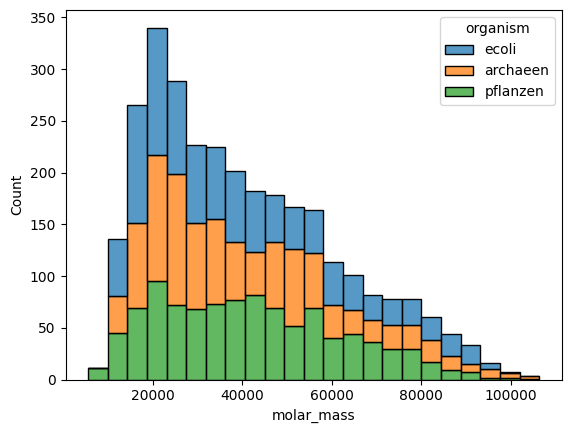

In [53]:
import seaborn as sns
import pandas as pd
import warnings

# Ignore seaborn warnings
warnings.filterwarnings("ignore")

# Step 1: Parse FASTA and convert into ProteinSequence
dna_sequences = DNASequence.read_fasta("all_sequences.fasta")
prot_sequences = [ProteinSequence.from_dna_sequence(dna_seq) for dna_seq in dna_sequences]

# Step 2: Create a DataFrame from the given data
df = pd.DataFrame([prot.__dict__ for prot in prot_sequences])

# Step 3: Visualize the distribution
sns.histplot(data=df, x="molar_mass", hue="organism", multiple="stack")

## Object-oriented vs procedual programming

We have covered the basics of Object-Oriented Programming (OOP) and have practiced exercises similar to those from the first part of this course. Although OOP and procedural programming often complement each other, there are specific situations where one approach may be more advantageous than the other.

Please list two scenarios for each paradigm where you believe it would be more effective. Support your choices with explanations based on what we have learned so far.

### OOP Cases

* **Data management**
  - **Reasoning:** In data management, the structure and behavior of data are key. OOP allows you to create classes that encapsulate data attributes and related methods, promoting data encapsulation, reuse, and maintenance. This approach makes it easier to manage complex relationships and interactions within the data, providing a clear and organized framework for data manipulation and querying.

* **Video games**
  - **Reasoning:** Video games often involve complex systems with many interacting entities, such as characters, items, and environments. OOP's ability to model real-world entities as objects with properties and behaviors is ideal for this. It allows for inheritance and encapsulation, which help in managing game states, behaviors, and interactions in a modular and scalable way. This results in more maintainable and extensible code.

### Procedural Cases

* **Data science/Machine Learning**
  - **Reasoning:** Data science and machine learning tasks often involve a series of linear, well-defined steps for data processing, analysis, and model training. Procedural programming is well-suited for such tasks because it emphasizes a clear sequence of actions and operations on data. This approach can make the code more straightforward and easier to follow, especially for tasks that do not require the complexity of OOP's abstractions.

* **Throw-away scripts**
  - **Reasoning:** Throw-away scripts are typically small, simple programs written to solve a specific problem or automate a task quickly. Procedural programming is ideal for these scenarios because it allows for rapid development and execution of straightforward, linear processes without the overhead of defining classes and objects. The simplicity and directness of procedural code make it a practical choice for short-lived scripts that do not need to be maintained or extended over time.